# Computational Methods for Astrophysics, Homework #2, Askold Vilkha

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from sympy import *
from sympy.utilities import lambdify

## Exercise 1, Root Finding Algorithm (Based on Bisection and Newton's methods)

In this problem, we are going to find roots for a function:
$$f(x) = \frac{(x + 5) ^ 3 + x + 5}{(x + 5) ^ 4 + 1} + \left(x + \frac{11}{2}\right) e^ {\cos(x + 5)}$$
We will numerically find the value of $x_0$, where the function $f(x_0) = 0$. Plot of this function is shown in Fig. 1. As a reference tool, we use function `optimize.root_scalar` from `scipy` package. It allows user to use a set of different methods, including Bisection and Newton's, and many more. 

In [33]:
def test_func(x: float) -> float:
    '''
    Function that will be used to test the algorithm
    '''
    res = (np.power(x + 5, 3) + x + 5) / (np.power(x + 5, 4) + 1) + (x + 11/2) * np.exp(np.cos(x + 5))
    return res

In [32]:
# reference value of the root
ref_root = optimize.root_scalar(test_func, bracket = [-20, 20])
ref_root

      converged: True
           flag: 'converged'
 function_calls: 15
     iterations: 14
           root: -5.349166623285174

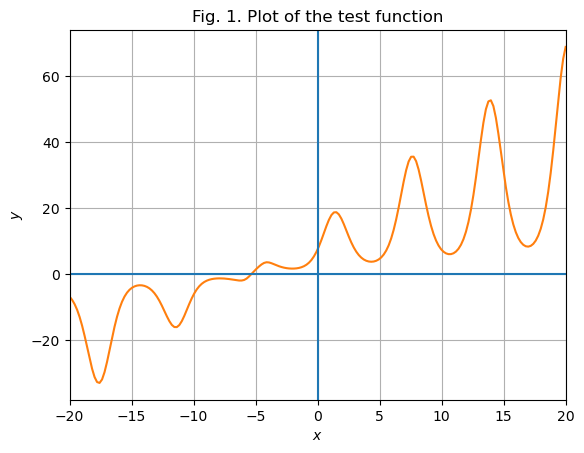

In [24]:
x_test = np.linspace(-20, 20, 200)
plt.plot(x_test, test_func(x_test), color = 'C1')
plt.axhline(y = 0, color = 'C0')
plt.axvline(x = 0, color = 'C0')
plt.xlabel(r'$x$'); plt.ylabel(r'$y$')
plt.xlim(-20, 20); plt.grid(True)
plt.title(r'Fig. 1. Plot of the test function');

In our algorithm, we use Bisection method as a tool to find a starting interval or point for another root finding algorithm. Bisection method is not the most efficient tool to find a precise root, but can be used to define approximate interval. The general idea is that we start with finding values of the function at the starting point $a$ and ending point $b$ (the user provides a bracket $[a, b]$). If they are of a different sign, we find a central point between them: $c = \frac{a + b}{2}$. The next step is to calculate $f(c)$. This will be a new value of $a$ or $b$ that we pass to the next iteration. The bracket $[a, b]$ has to be defined in such a way that $f(a)$ and $f(b)$ have different signs. Therefore, if $f(c)$ is of the same sign as the starting $f(a)$, then new bracket will be $[c, b]$, if signs are different, then it will be $[a, c]$. Then, we pass the new bracket to the next iteration, and repeat the process. Stopping condition is when the interval $[a, b]$ or $|f(c)|$ is smaller than some critical value defined by user. Note, that this method is almost brute force, so it is slower than other ones. For example, using function `optimize.root_scalar` and Bisection method, we need 45 iterations, three times more than initial 15 iterations in the example above. Also, if you choose the bracket that does not contain the actual root, it will fail. It is a good idea to plot the function first, and decide on the bracket after seeing the plot. In Fig. 2, we show a few steps of Bisection method. (source: https://en.wikipedia.org/wiki/Bisection_method#/media/File:Bisection_method.svg) 
This algorithm is implemented in the function `rootfinder_bisect`

In [81]:
# example of the bisection method root finder
ref_root_bisect = optimize.root_scalar(test_func, method = 'bisect', bracket = [-20, 20])
ref_root_bisect

      converged: True
           flag: 'converged'
 function_calls: 47
     iterations: 45
           root: -5.349166623285555

![Alternative-text](bisect_rescaled.png)
$$
\text{Fig. 2 Bisection root finding method}
$$

In [114]:
def rootfinder_bisect(func, bracket: list, x_stop: float = 1e-5, y_stop: float = 1e-5, it_limit: int = 0, return_bracket: bool = False):
    '''
    Function that contains the Bisection root finding method. Can return either a bracket that contains a root, or approximate root value, and the number of iterations \n
    Input: func (function) -  function that the user wants to find the roots of \\
    bracket (list) - list of 2 elements  [a, b], which is an interval where user wants to find the roots \\
    x_stop (float) (optional) - if the interval length at some iteration is smaller than x_stop, the algorithm will stop and give the answer, must be positive! \\
    y_stop (float) (optional) - if |func(x)| < y_stop at some iteration, the algorithm will stop and give the answer, must be positive! \\
    Note. If you change y_stop but still get the same number of iterations, consider making x_stop smaller so the function stops at reaching y_stop. Vice versa if you change x_stop. \\
    it_limit (int) (optional) - maximum number of iterations of the algorithm, must not be negative, if zero, it will be ignored \\
    return_bracket (bool) (optional) - if True, the function will return the bracket that contains the root, if False, approximate root value \n
    Output: res - bracket that contains the root, or approximate root value, depending on the return_bracket parameter \\
    it (int) - number of iterations
    '''
    if len(bracket) > 2:
        raise ValueError(bracket, r'Bracket must not contain more than 2 arguments!')
    if x_stop <= 0:
        raise ValueError(x_stop, r'x_stop must be positive!')
    elif y_stop <= 0:
        raise ValueError(y_stop, r'y_stop must be positive!')
    if it_limit < 0:
        raise ValueError(it_limit, r'it_limit must not be negative!')
    if sign(func(bracket[0])) == sign(func(bracket[1])):
        print(r'The bracket does not contain the root, please choose a different one!')
        return None
    
    bracket.sort()
    max_it = 1e4; it = 0
    if it_limit > 0:
        max_it = it_limit
    
    # main algorithm
    x_c = (bracket[1] + bracket[0]) / 2
    while np.abs(bracket[1] - bracket[0]) >= x_stop and np.abs(func(x_c)) >= y_stop and it < max_it:
        x_a = bracket[0]; x_b = bracket[1]
        x_c = (bracket[1] + bracket[0]) / 2

        if sign(func(x_c)) == sign(func(x_a)): 
            x_a = x_c # if signs for f(a) and f(c) are the same, we should move to [c, b] interval
        else:
            x_b = x_c # if signs for f(a) and f(c) are different, then our new interval is [a, c]
        
        bracket = [x_a, x_b]
        it = it + 1

    res_bracket = bracket
    if return_bracket:
        return res_bracket, it
    else:
        return x_c, it

Now, we can test this function to see if the root will be close to the reference root. 

In [116]:
root_bisect = rootfinder_bisect(test_func, [-20, 20])
print(r'Error of the algorithm with default settings is %g, number of iterations: %i'%(root_bisect[0] - ref_root.root, root_bisect[1]))

Error of the algorithm with default settings is -2.15418e-06, number of iterations: 22
